# Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import warnings
from data_preparation import *
import imblearn
from collections import Counter
from imblearn.under_sampling import NearMiss
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap

warnings.filterwarnings("ignore")

# Dataprep train dataset

In [188]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
test_prepared = pd.read_csv('./data/test_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

In [190]:
df_app['AMT_INCOME_TOTAL']

0         292500.0
1         180000.0
2          67500.0
3         157500.0
4         112500.0
            ...   
306102    148500.0
306103     90000.0
306104    157500.0
306105     63000.0
306106    135000.0
Name: AMT_INCOME_TOTAL, Length: 306107, dtype: float64

In [117]:
train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()

In [118]:
train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
test_prepared['CODE_GENDER'] = test_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

In [119]:
train_prepared.drop(columns = 'Unnamed: 0', inplace = True)

# Dataprep CB_balance dataset

In [120]:
train_prepared.shape

(306107, 36)

In [121]:
cb = pd.read_csv('./data/credit_card_balance.csv')

In [122]:
print(f'nb lignes : {cb.shape[0]} vs nb id uniques : {cb.SK_ID_CURR.nunique()}')

nb lignes : 3840312 vs nb id uniques : 103558


In [123]:
cb_mean = cb[['CNT_DRAWINGS_CURRENT','AMT_CREDIT_LIMIT_ACTUAL','CNT_DRAWINGS_ATM_CURRENT','AMT_PAYMENT_CURRENT','SK_ID_CURR']].groupby('SK_ID_CURR').mean()
cb_mean = cb_mean.reset_index()
#cb_mean['NAME_CONTRACT_STATUS'] = cb[['NAME_CONTRACT_STATUS','SK_ID_CURR']].groupby('SK_ID_CURR').mode()
cb_mean.shape

(103558, 5)

In [125]:
train_cb = pd.merge(train_prepared,cb_mean, on = 'SK_ID_CURR',how='left')

In [126]:
train_cb.shape

(306107, 40)

In [134]:
for col in ['CNT_DRAWINGS_CURRENT','AMT_CREDIT_LIMIT_ACTUAL','CNT_DRAWINGS_ATM_CURRENT','AMT_PAYMENT_CURRENT']:
    train_cb[col] = train_cb[col].fillna(0)
    
train_prepared = train_cb.copy()

# NaN

In [135]:
for col in train_prepared.select_dtypes(include='number').columns:
    moyenne = train_prepared[col].mean()
    train_prepared[col] = train_prepared[col].fillna(moyenne)

# One hot encoding

In [136]:
for col in train_prepared.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared[col], prefix=col, drop_first=True)
    train_prepared = train_prepared.drop(col, axis=1)
    train_prepared = train_prepared.join(one_hot_encoded)

for col in train_prepared.select_dtypes(include=bool).columns:
    train_prepared[col] = train_prepared[col].astype(int)
    

In [152]:
new_columns = []
for col in train_prepared.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

train_prepared.columns = new_columns


# Train,Test split

In [179]:
liste_var =['EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_']#,
       #'EXT_SOURCE_1_disc_int__0_41_0_96_', 'CODE_GENDER_M',
       #'NAME_EDUCATION_TYPE_discret_lower',
       #'DAYS_EMPLOYED_disc_int___2443_365243_',
       #'DAYS_BIRTH_disc_int___25229__19283_', 'FLAG_OWN_CAR_Y',
       #'NAME_INCOME_TYPE_discret_other', 'CNT_DRAWINGS_ATM_CURRENT',
       #'AMT_GOODS_PRICE_disc_int__679500_0_4050000_0_',
       #'AMT_CREDIT_LIMIT_ACTUAL']

In [180]:
X = train_prepared[liste_var].copy()

y = train_prepared['TARGET'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
#X_train.drop(columns = ['TARGET'],inplace =True)
#X_test.drop(columns = ['TARGET'],inplace =True)

# Logit

In [181]:
#X_train = X_train[selected_variables_names]
#X_test = X_test[selected_variables_names]

In [184]:
model = LogisticRegression()#penalty = 'elasticnet',solver = 'saga',random_state=42,l1_ratio = 0.5)
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[56525     0]
 [ 4697     0]]


In [185]:
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6570393346765329


# Corretion noms colonnes

In [186]:
new_columns = []
for col in X_train.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train.columns = new_columns


new_columns = []
for col in X_test.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test.columns = new_columns

# Xgboost

In [187]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',3, 10),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred,output_dict=True)
    f_one = report['1']['f1-score']
    
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return roc_auc

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive auc score: {study.best_value}")


[I 2024-02-21 11:12:36,970] A new study created in memory with name: no-name-79dc9d8f-459c-4546-a0b8-61a8ddb5c019
[I 2024-02-21 11:12:37,911] Trial 0 finished with value: 0.6570393346765329 and parameters: {'max_depth': 7, 'eta': 0.3043785028389846, 'gamma': 0.023809656169233785, 'colsample_bytree': 0.7078218042482319, 'subsample': 0.8363554869736465, 'n_estimators': 101, 'alpha': 0.26174335931701237}. Best is trial 0 with value: 0.6570393346765329.
[I 2024-02-21 11:12:38,517] Trial 1 finished with value: 0.6570393346765329 and parameters: {'max_depth': 9, 'eta': 0.29779179870331046, 'gamma': 0.0011521695248121692, 'colsample_bytree': 0.9689412486217495, 'subsample': 0.8421695460880472, 'n_estimators': 119, 'alpha': 0.2653797957067494}. Best is trial 0 with value: 0.6570393346765329.
[I 2024-02-21 11:12:39,171] Trial 2 finished with value: 0.6570393346765329 and parameters: {'max_depth': 5, 'eta': 0.10051941830938058, 'gamma': 1.5873068633640145e-05, 'colsample_bytree': 0.7770588001483

KeyboardInterrupt: 

In [175]:
report = classification_report(y_test,y_pred,output_dict=True)
report['1']['f1-score']

0.0

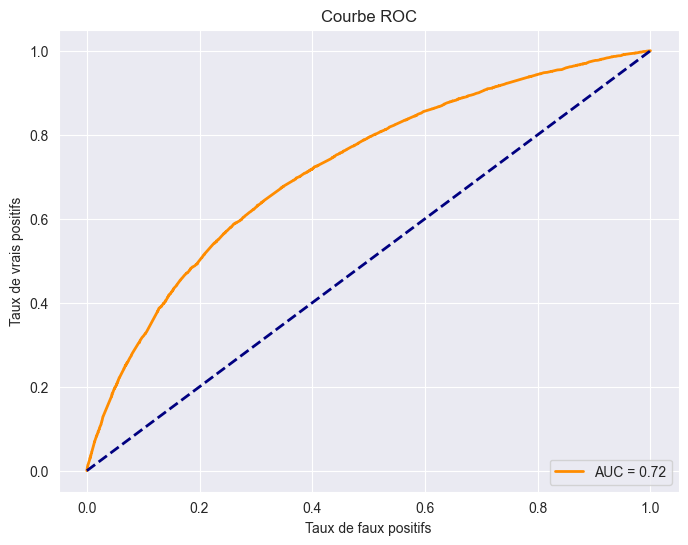

In [176]:
params = study.best_params

model = xgb.XGBClassifier(**params)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

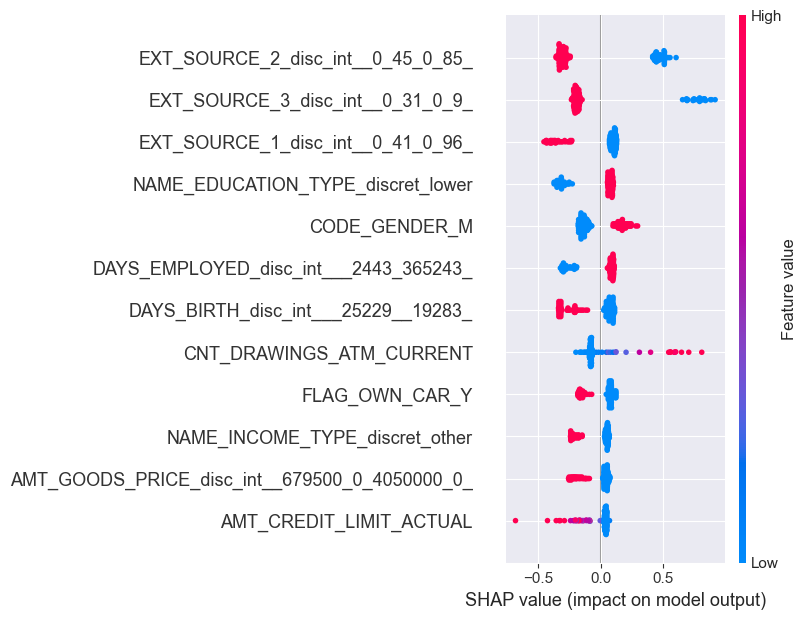

In [177]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train.iloc[:150, :])

shap.summary_plot(shap_values, X_train.iloc[:150, :])

shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [178]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 12
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_',
       'EXT_SOURCE_1_disc_int__0_41_0_96_',
       'NAME_EDUCATION_TYPE_discret_lower', 'CODE_GENDER_M',
       'DAYS_EMPLOYED_disc_int___2443_365243_',
       'DAYS_BIRTH_disc_int___25229__19283_', 'CNT_DRAWINGS_ATM_CURRENT',
       'FLAG_OWN_CAR_Y', 'NAME_INCOME_TYPE_discret_other',
       'AMT_GOODS_PRICE_disc_int__679500_0_4050000_0_',
       'AMT_CREDIT_LIMIT_ACTUAL'],
      dtype='object')

Variables à garder de credit_balance : 

['CNT_DRAWINGS_CURRENT','AMT_CREDIT_LIMIT_ACTUAL','CNT_DRAWINGS_ATM_CURRENT','AMT_PAYMENT_CURRENT']